In [ ]:
%cd /content/drive/MyDrive/Medical-Image-Segmentation/Code/data-science-bowl-2018

/content/drive/MyDrive/Medical-Image-Segmentation/Code/data-science-bowl-2018


In [ ]:
import os 
import random 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

# Data Overview

* The competetion was held in two stages. 
* stage1_train - training set images (images and annotated masks)
* stage1_test - stage 1 test set images (images only, you are predicting the masks). We have the solutions to the stage1_test hence this acts as a validation set.
* stage1_solutions - Solutions to stage1_test 
* stage2_test (released later) - stage 2 test set images (images only, you are predicting the masks)
* stage1_sample_submission.csv - a submission file containing the ImageIds for  which you must predict during stage 1
* stage2_sample_submission.csv (released later) - a submission file containing the ImageIds for which you must predict during stage 2
* stage1_train_labels.csv - a file showing the run-length encoded representation of the training images. This is provided as a convenience and is redundant with the mask image files.
------------------
* Thus for now, the stage1_train, stage1_test, and stage2_test_final will act as train, val and test set respectively

In [ ]:
TRAIN_PATH = 'data/stage1_train/'
VAL_PATH = 'data/stage1_test/'
TEST_PATH = 'data/stage2_test_final/'

train_ids = next(os.walk(TRAIN_PATH))[1]
val_ids = next(os.walk(VAL_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print('number of train instances:',len(train_ids))
print('number of validation instances:',len(val_ids))
print('number of test instances:',len(test_ids))

number of train instances: 670
number of validation instances: 65
number of test instances: 3019


In [ ]:
def get_image(id, data='train'):
  """reads image using its id and returns it in numpy format"""
  
  if data =='train':
    img = imread(TRAIN_PATH + id + '/images/' + id + '.png')
  elif data =='val':
    img = imread(VAL_PATH + id + '/images/' + id + '.png')
  elif data =='test':
    img = imread(TEST_PATH + id + '/images/' + id + '.png')
  return img

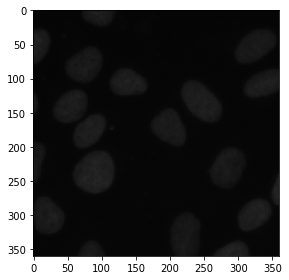

shape of image (360, 360, 4)
range of values 255 4


In [ ]:
#Seeing a random image
ind = np.random.randint(0, len(train_ids))
sample_img = get_image(train_ids[ind])
imshow(sample_img)
plt.show()

print('shape of image',sample_img.shape)
print('range of values', np.max(sample_img), np.min(sample_img))

# Checking Basic Image Properties


* Its important to check the basic image properties to make sure every image is in the same format. Properties like scale of pixels, number of channels, size should be same. 
* It is also important to see if there aren't any outliers/bad training images. This can be done through manual observation and also through observing the basic properties as mentioned above. 

In [ ]:
# channels = []
# max_pixel = []
# min_pixel = []

# for i in tqdm(train_ids):
#   img = get_image(i,'train')
#   channels.append(img.shape[2])
#   max_pixel.append(np.max(img[:,:,:3]))
#   min_pixel.append(np.min(img[:,:,:3]))

# print('unique channels', np.unique(channels))
# print('min of max_pixel', np.min(max_pixel))
# print('min of min_pixel', np.min(min_pixel))


unique channels [4]
min of max_pixel 30
min of min_pixel 0


In [ ]:
# channels = []
# max_pixel = []
# min_pixel = []

# for i in tqdm(val_ids):
#   img = get_image(i,'val')
#   channels.append(img.shape[2])
#   max_pixel.append(np.max(img[:,:,:3]))
#   min_pixel.append(np.min(img[:,:,:3]))

# print('unique channels', np.unique(channels))
# print('min of max_pixel', np.min(max_pixel))
# print('min of min_pixel', np.min(min_pixel))


unique channels [3 4]
min of max_pixel 76
min of min_pixel 0


In [ ]:
rare_grayscale = '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0'
rare_grayscale = get_image(rare_grayscale, 'test')
rare_grayscale.shape

(1024, 1360)

* There are two types of images found in train and val data: RGB and RGBA (4 channels). The last channel is called the alpha channel which decides the transparency (255 being opaque and 0 being transparent). Removing this channel will convert our image into an RGB image.
* On close inspection of test data, I found that there is only one image rare_grayscale which is a grayscale image. Rest all other images are either RGB or RGBA. 
* Images are found in different sizes.
* All images are in 0-255 scale only. No image is found to be in 0-1 scale. 

# Going Through the Images

**Train Images**

In [ ]:
#Printing 100 random images. 
for i in range(100):
  ind = np.random.randint(0, len(train_ids))
  print(train_ids[ind])
  imshow(get_image(train_ids[ind]))
  plt.show()

**Validation Images**

In [ ]:
#Printing all 65 val images
for id in val_ids:
  print(id)
  imshow(get_image(id, 'val'))
  plt.show()

**Test Images**

In [ ]:
#Printing 100 random images. 
for i in range(100):
  ind = np.random.randint(0, len(test_ids))
  print(test_ids[ind])
  imshow(get_image(test_ids[ind], 'test'))
  plt.show()

* In train data, most images are black and white. Some are colored. The black and white images look easy to segment from the human eye. The colored images are generally purple in color. The train images dont have a lot of variation in them. Show below are the general variations found. Most images resemble one of the five shown below. 

sample train images


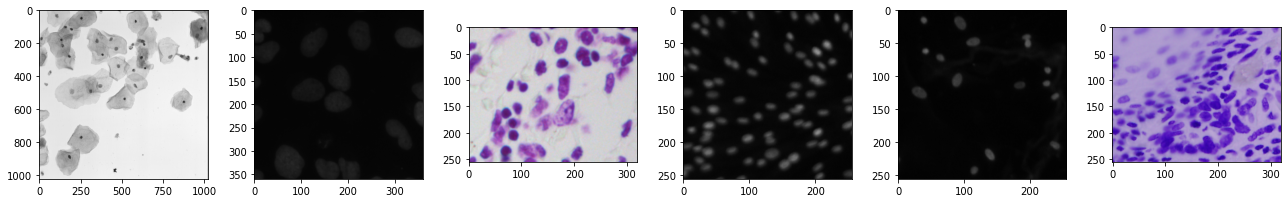

In [ ]:
sample_train_ids = ['3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04','50a7ea80dd73232a17f98b5c83f62ec89989e892fe25b79b36f99b3872a7d182', '337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf', '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e', '8e8a7a14749d0b2e48de3d10e2e80063f17b165ad921c8afc0623f08500f3259', 'f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886']

print('sample train images')
fig, axes = plt.subplots(1, 6, figsize=(18, 10))
ax = axes.ravel()
for i in range(6):
  ax[i].imshow(get_image(sample_train_ids[i]))
fig.tight_layout()
plt.show()

* The val images contain are also like the train images but a little more variations. The backgrounds for both train and val images are very similar.

* The test images on the other hand contain a lot more variations. This is the challenging part about the task, that the test images are taken in different background conditions which might not be found in train data and our model needs to be able to generalize better. 

sample val images


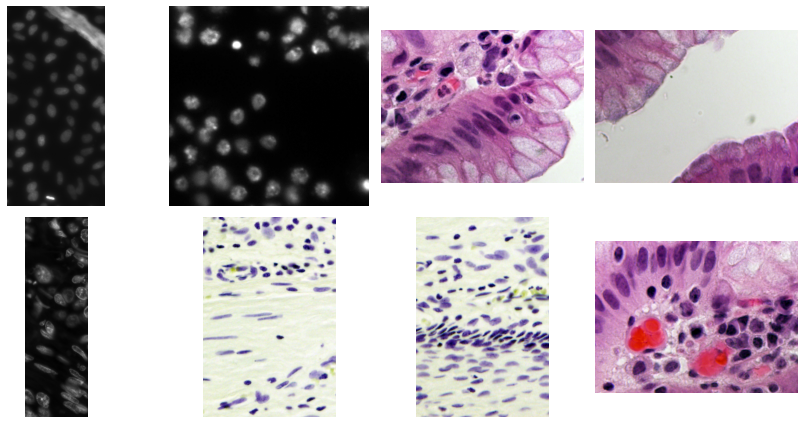

In [ ]:
sample_val_ids = ['0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac','0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732','0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466', '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff', '1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a', '1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1','3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26', '472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71']

print('sample val images')
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
ax = axes.ravel()
for i in range(8):
    ax[i].imshow(get_image(sample_val_ids[i], 'val'))
    ax[i].axis('off')
fig.tight_layout()
plt.show()

sample test images different from train images


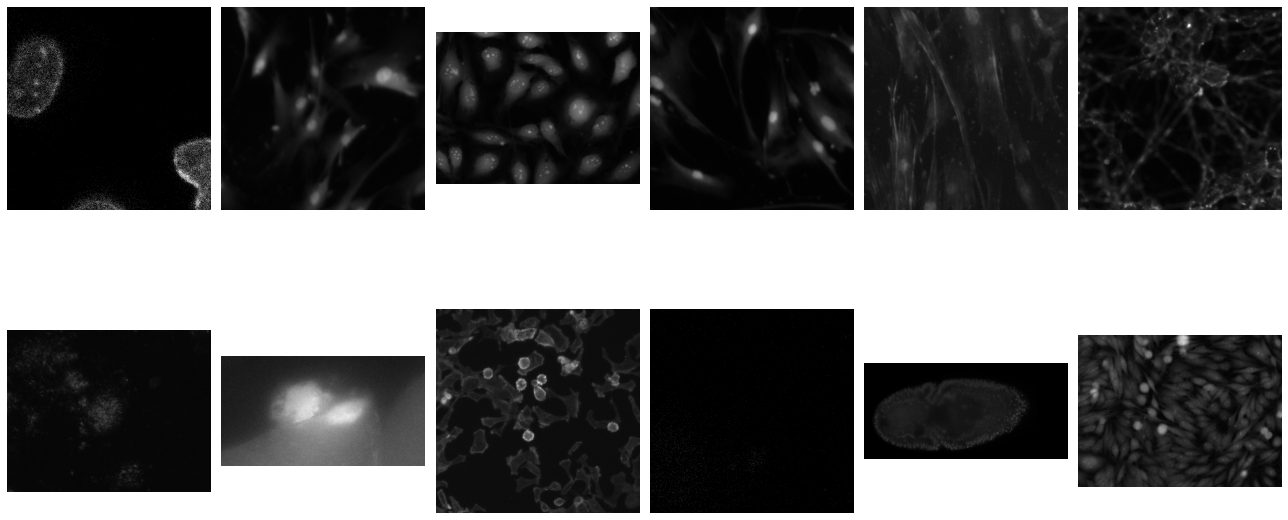

In [ ]:
sample_test_ids = ['dbd9dce0aed27ec69f7a47c8b715ad52e1dad472d82f9bf050470007dc1af94e','25ae6da0f1ced38fc87aff6fad90f9980062fa4d18161904364f5b95a20422a4','580fb557444d914797839fadecc9d6d60aa7c2eb98e854bafa014b3a13d27ddd','e0480625325c11f096d540a8cda158397095e0efa287fe7b0658477566ee48c8','a7e5aa0e0b11c89f436dfebd2a1343739a69d065b3f78a0a11fdb65afd6f7457', '861a0fa08ceacdc6372728920d313a9b80257086e8e733e92d9c18c257ec9e93', '2fa8719a414b802474497eb5b3261f2e3903a75ec21534ffca674e1555072519', 'ce5176e721adba76663e9bdcc47c3ba0c70110573da99cf314a38d7eea070680', '20d0d2ac8ecc95216d056b46163466a18b7f74c921e9f2b5e46e538a58de65e6', '1028160a0e29d080fff27b2d8a119938fa8dbc86b1c88c3ea452b048191e1d79','f3a512375cbe51d56efeb8a644923cf884eb23c06810f0218407c74225d83eab', 'e90773e64b055d3ea09210c5f9803dba7126a717dc0baece319d2c9505e363c5']

print('sample test images different from train images')
fig, axes = plt.subplots(2, 6, figsize=(18, 10))
ax = axes.ravel()
for i in range(12):
    ax[i].imshow(get_image(sample_test_ids[i], 'test'))
    ax[i].axis('off')
fig.tight_layout()
plt.show()

# Masks

In [ ]:
ind = random.randint(0, len(train_ids))
pth = TRAIN_PATH + train_ids[ind] + '/masks/'

masks_pths = os.listdir(pth)

sample_mask = imread(pth+masks_pths[0])
print('shape:', sample_mask.shape)
print('unique pixels:', np.unique(sample_mask))

shape: (520, 696)
unique pixels: [  0 255]


### Generating the combined masks for train images

* The complete mask for an image is seperated into different nuclei. But the way we will train our NN, we would have to combine it first. 
* There are two ways to combine the masks. 
  * Combine each mask taking the max value of pixels at each step. 
  * Reconstruct/Decode the image from the encoded labels in stage1_train_labels. 

In [ ]:
#https://www.kaggle.com/stainsby/fast-tested-rle-and-input-routines

def rle_decode(rle_str, mask_shape):
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), 'uint8')
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1.0
    return mask.reshape(mask_shape[::-1]).T

def merge_masks(directory, target_size=None):
    """Read and resize masks contained in a given directory."""
    for i,filename in enumerate(next(os.walk(directory))[2]):
        mask_path = os.path.join(directory, filename)
        mask_tmp = imread(mask_path, as_gray=True)
        if not i: mask = mask_tmp
        else: mask = np.maximum(mask, mask_tmp)
    return mask

In [ ]:
#Reading the labels and then grouping to get the merged masks labels
stage1_train_labels = pd.read_csv('data/stage1_train_labels.csv')
stage1_train_labels['labels'] = stage1_train_labels.groupby('ImageId')['EncodedPixels'].transform(lambda x: ' '.join(x))
train_labels_df = stage1_train_labels.drop_duplicates('labels').drop('EncodedPixels', axis=1)
print(train_labels_df.shape)
train_labels_df.head(1)

(670, 2)


,ImageId,labels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...


**Demonstration of each method**

47


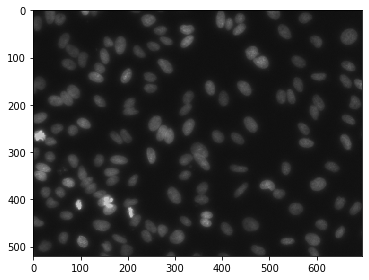

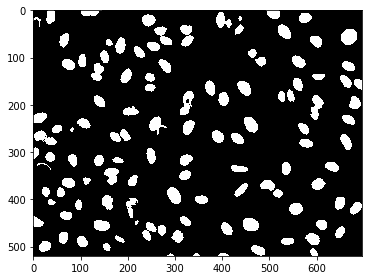

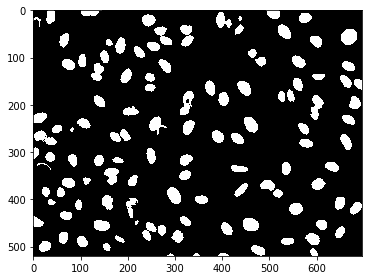

Merged Mask == Decoded Mask : True


In [ ]:
#generating a random img path
ind = np.random.randint(0, len(train_labels_df))
print(ind)
#Image
img = get_image(train_labels_df['ImageId'].iloc[ind])
imshow(img)
plt.show()
#Merged Masks
dir_ = TRAIN_PATH + train_labels_df['ImageId'].iloc[ind] + '/masks/' 
merged_mask = merge_masks(dir_)
imshow(merged_mask)
plt.show()
#Decoding from Labels
decoded_mask = rle_decode(train_labels_df['labels'].iloc[ind], img.shape[:2])
imshow(decoded_mask*255)
plt.show()
print('Merged Mask == Decoded Mask :', np.all(merged_mask == decoded_mask*255))

* I compared for 100 random images and both the methods yeild the same mask. 
* I will use the decoding technique as it is much faster and easier. In merging, we have to make sure all masks are in same scale pixelwise and shapewise. And to check for outliers/bad images. None of this needs to be taken care of while decoding from labels.

**Extracting and saving masked images (using decoding)**
* Saving the masked images in 'merged' folder


In [ ]:
# from PIL import Image

# for i in tqdm(range(len(train_labels_df))):
#   id = train_labels_df['ImageId'].iloc[i]
#   img = get_image(id)
#   #Decoding from Labels
#   decoded_mask = rle_decode(train_labels_df['labels'].iloc[i], img.shape[:2])
#   im = Image.fromarray(decoded_mask*255)
#   os.mkdir(TRAIN_PATH + id + '/merged/')
#   im.save(TRAIN_PATH + id + '/merged/' + id + '.png')

**Sanity Check and Visualization**

In [ ]:
def get_mask(id, data='train'):
  """reads mask using its id and returns it in numpy format"""

  if data =='train':
    img = imread(TRAIN_PATH + id + '/merged/' + id + '.png')
  elif data =='val':
    img = imread(VAL_PATH + id + '/merged/' + id + '.png')
  elif data =='test':
    img = imread(TEST_PATH + id + '/merged/' + id + '.png')
  return img

In [ ]:
sanity_df = train_labels_df['ImageId'].copy()

for id in sanity_df:
  print(id)
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))
  ax = axes.ravel()
  ax[0].imshow(get_image(id, 'train'))
  ax[1].imshow(get_mask(id, 'train'), cmap='gray')
  fig.tight_layout()
  plt.show()

In [ ]:
dimensions = []
shapes = []
unique_pixel_vals = []

for i, id in tqdm(enumerate(sanity_df), total=len(sanity_df)):
  msk = get_mask(id, 'train')
  dimensions.append(np.ndim(msk))
  shapes.append(msk.shape)
  unique_pixel_vals.append(np.unique(msk))

print(np.unique(dimensions))
print(np.unique(shapes))
print(np.unique(unique_pixel_vals))  


[2]
[ 256  260  320  347  360  512  520  603  640  696 1024 1040 1272 1388]
[  0 255]


* Different Shapes, Pixel values are 0 and 255 i.e. same pixel range, all have dimensions of 2
* While going through the images and masks manually, we observe that there is one image for which the mask is incorrectly labeled. 

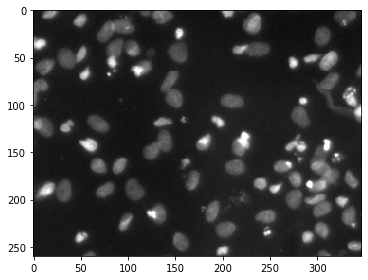

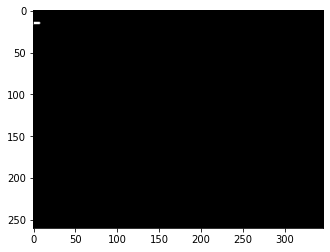

In [ ]:
bad_image_id = '7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80'
bad_image = get_image(bad_image_id, 'train')
bad_image_mask = get_mask(bad_image_id, 'train')
imshow(bad_image)
plt.show()
plt.imshow(bad_image_mask, cmap='gray')
plt.show()

* We are going to remove this image while training

### Saving Masked Images for validation set


In [ ]:
stage1_solution = pd.read_csv('./data/stage1_solution.csv')
stage1_solution.head(1)

,ImageId,EncodedPixels,Height,Width,Usage
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...,256,256,Public


In [ ]:
stage1_solution['labels'] = stage1_solution.groupby('ImageId')['EncodedPixels'].transform(lambda x: ' '.join(x))
val_labels_df = stage1_solution.drop_duplicates('labels')[['ImageId', 'labels']]
print(val_labels_df.shape)
val_labels_df.head(1)

(65, 2)


,ImageId,labels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...


In [ ]:
# from PIL import Image

# for i in tqdm(range(len(val_labels_df))):
#   id = val_labels_df['ImageId'].iloc[i]
#   img = get_image(id, 'val')
#   #Decoding from Labels
#   decoded_mask = rle_decode(val_labels_df['labels'].iloc[i], img.shape[:2])
#   im = Image.fromarray(decoded_mask*255)
#   os.mkdir(VAL_PATH + id + '/merged/')
#   im.save(VAL_PATH + id + '/merged/' + id + '.png')

**Sanity Check and Visualization**

In [ ]:
sanity_df = val_labels_df['ImageId'].copy()

for id in sanity_df:
  print(id)
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))
  ax = axes.ravel()
  ax[0].imshow(get_image(id, 'val'))
  ax[1].imshow(get_mask(id, 'val'), cmap='gray')
  fig.tight_layout()
  plt.show()

In [ ]:
dimensions = []
shapes = []
unique_pixel_vals = []

for i, id in tqdm(enumerate(sanity_df), total=len(sanity_df)):
  msk = get_mask(id, 'val')
  dimensions.append(np.ndim(msk))
  shapes.append(msk.shape)
  unique_pixel_vals.append(np.unique(msk))

print(np.unique(dimensions))
print(np.unique(shapes))
print(np.unique(unique_pixel_vals))

[2]
[161 162 239 253 256 260 347 348 390 512 519 520 524 640 680 696]
[  0 255]


* Different Shapes, Pixel values are 0 and 255 i.e. same pixel range, all have dimensions of 2
* There seems to be no bad images while going through them manually.

# Summary

* We have three sets of images
  * stage1_train - 670 images with labels - act as training set
  * stage1_test - 65 images with labels - act as validation set
  * stage2_test_final - 3019 images without labels - act as test set
* All the images are found either in RGB or RGBA format. There is only one exception in test set which is grayscaled with only 2 dimensions. The id of images is '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0'
* Every image has pixel scale of 0-255 and none between 0-1. 
* Images are found in different sizes.
* The combined mask of every image is stored in the merged folder. This is for train and val set. The pixel vals of these masks are in 0-255 scale. 
* There is one bad training image for which the mask is labeled incorrectly. We will remove this image while training. The id is '7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80'
